In [11]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import csv

In [12]:
address = 'New Data\Video7.mov'
title = address.split('.')[0]
cap = cv2.VideoCapture(address)
fps = cap.get(cv2.CAP_PROP_FPS)

init_time = 22  # seconds
cap.set(cv2.CAP_PROP_POS_MSEC, init_time * 1000)

center = (537, 160)

# capture one frame
ret, frame = cap.read()

# If homography desired (UNIMPLEMENTED!!!): 
# orig_pts = np.array([(137, 38), (904, 70), (97, 780), (962, 780)])
# dest_pts = np.array([(0,0), (1020, 0), (0,780), (1020, 780)])
# homography = cv2.findHomography(orig_pts, dest_pts)[0]
# print(homography)

In [13]:
# Video 5: 
# - Center (500, 160)

# Video 9: 
# - Center ()
# - 

# Video 10: 
# - Center (537, 160)
# - Start time: 22

# Video 11: 
# - Frame cuts: 250, 150, 450, 450
# - Start time: 15

# Video 15: 
# - Center (563, 160)
# - Start time: 

# Video 16: 
# - Frame cuts: 180, 120, 600, 300
# - Center (643, 100) 
# - Start time: 17

# Video 20: 
# - Frame cuts: 
# Homography Original: (137, 38), (904, 70), (97, 780), (962, 780)
# Homography Image: (0,0), (1020, 0), (0,780), (1020, 780)

1920 1080


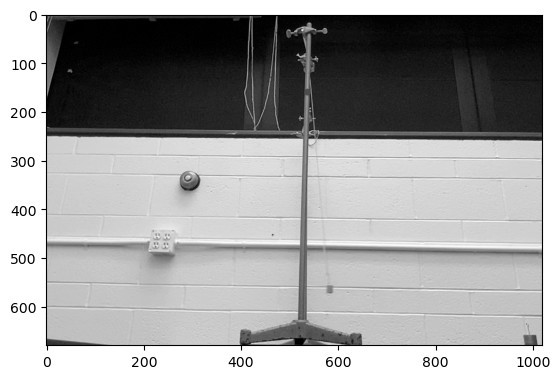

In [14]:
frame_cols = frame.shape[1]
frame_rows = frame.shape[0]
print(frame_cols, frame_rows)

if (frame_cols, frame_rows) == (1920, 1080):
    rope_len_irl = 74  #cm 
    rope_len_1 = np.array([534, 86])
    rope_len_2 = np.array([152, 301])
    rope_len_pixel = np.sqrt(sum((rope_len_1 - rope_len_2) ** 2))
    len_pixel_ratio = rope_len_irl / rope_len_pixel

    # determine values by yourself
    frame_top_cut = 250 
    frame_bottom_cut = 150 
    frame_left_cut = 450 
    frame_right_cut = 450 
    frame = frame[frame_top_cut:-frame_bottom_cut, frame_left_cut:-frame_right_cut]
    cv2.imwrite('frame.jpg', frame)
    frame_cols -= frame_left_cut+frame_right_cut
    frame_rows -= frame_top_cut+frame_bottom_cut

    # frame = cv2.warpPerspective(frame, homography, (frame_cols, frame_rows)) 

    cv2.circle(frame, center, 7, (0, 0, 255), -1)

    cvt_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    cv2.imwrite('picker.jpg', cvt_frame)
    plt.imshow(cvt_frame, cmap='gray')

In [15]:
def update_cuts_2(tracked, top, left, right, bottom):
    tracked = np.array(tracked)
    recent_coords = tracked[-50:, :]
    min_col = min(recent_coords[:, 0])
    max_col = max(recent_coords[:, 0])
    min_row = min(recent_coords[:, 1])
    max_row = max(recent_coords[:, 1])
    # print(min_row, min_col, max_col, max_row)
    return min_row-20, min_col-20, max_col+20, max_row+20

In [16]:
cv2.namedWindow("output", cv2.WINDOW_NORMAL)

# Resize window to specified dimensions
cv2.resizeWindow("output", frame_cols, frame_rows)              

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

backSub = cv2.createBackgroundSubtractorMOG2()
global_centers = []
frame_no = 0
frame_lst = []

top_cut = 250
left_cut = 100
right_cut = frame_cols - 50
bottom_cut = frame_rows - 100
time = 0
max_pixel_vals = [[], []]

while time <= 120 and (cap.isOpened()):

    ret, frame = cap.read()
    frame = frame[frame_top_cut:-frame_bottom_cut, frame_left_cut:-frame_right_cut]
    frame_no += 1
    time = frame_no/fps 
    # print('Frame number:', frame_no)

    if ret == True: 
        # new_frame = cv2.warpPerspective(frame, homography, (frame_cols, frame_rows)) 

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        retval, bw_frame = cv2.threshold(gray_frame, 180, 255, cv2.THRESH_BINARY)
        retval, bw_frame_endpoints = cv2.threshold(gray_frame, 140, 255, cv2.THRESH_BINARY)

        fg_mask_1 = backSub.apply(bw_frame)
        fg_mask_endpoints = backSub.apply(bw_frame_endpoints)
        fg_lst = [fg_mask_1, fg_mask_endpoints]

        # Define your minimum and maximum area threshold
        local_centers = []
        i = -1

        for fg_mask in fg_lst: 
            i += 1
            fg_mask[0:top_cut, :] = 0
            fg_mask[:, 0:left_cut] = 0
            fg_mask[:, right_cut:] = 0
            fg_mask[bottom_cut:, :] = 0

            if frame_no > 1:

                blurred = cv2.GaussianBlur(fg_mask, (11,15), 100)
                # set the kernal
                kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
                # Apply erosion
                mask_eroded = cv2.morphologyEx(blurred, cv2.MORPH_OPEN, kernel)
                # Apply dilation 
                mask_dilated = cv2.dilate(mask_eroded, kernel, iterations=1)
                
                max_pixel_vals[i].append(np.max(mask_dilated))
                # print(max_pixel_vals[i])
                if i == 0: 
                    my_pixel_val = np.average(max_pixel_vals[i]) - 10 
                if i == 1: 
                    my_pixel_val = np.average(max_pixel_vals[i]) - 10 
                # print(my_pixel_val)

                retval, bw_frame_new = cv2.threshold(mask_dilated, my_pixel_val, 255, cv2.THRESH_BINARY)

                # Find contours
                contours, hierarchy = cv2.findContours(bw_frame_new, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                # print(contours)

                for c in contours:
                    # compute the center of the contour
                    M = cv2.moments(c)
                    cX = int(M["m10"] / M["m00"])
                    cY = int(M["m01"] / M["m00"])
                    local_centers.append(np.array([cX, cY]))

                # If you want to see the detected contours, useful for optimizing mass detection
                frame = cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)

        cur_coord = None
        if frame_no == 2: 
            global_centers = [[i] for i in local_centers]
            frame_lst.append(frame_no)
            # print(global_centers)
        else: 
            tracked_coords = []
            flag = False
            for i in range(0, len(global_centers)):
                coords_so_far = global_centers[i]
                prev_coord = coords_so_far[-1]
                threshold_dist = 250
                min_dist_so_far = 0
                best_coord_so_far = None
                for coord in local_centers:
                    x_diff = coord[0] - prev_coord[0]
                    y_diff = coord[1] - prev_coord[1]
                    dist = np.sqrt(x_diff ** 2 + y_diff ** 2) 
                    if dist < threshold_dist and abs(y_diff) < 100: 
                        best_coord_so_far = coord
                        min_dist_so_far = dist
                if best_coord_so_far is not None: 
                    coords_so_far.append(best_coord_so_far)
                    flag = True
                    cv2.circle(frame, (coords_so_far[-1][0], coords_so_far[-1][1]), 7, (0, 0, 0), -1)
                tracked_coords.append(coords_so_far)
            global_centers = tracked_coords
            if flag == True: 
                frame_lst.append(frame_no)
            else: 
                print('Nothing')

            # Update region of interest every 20 frames
            if frame_no % 50 == 0: 
                if len(global_centers) == 1:
                    tracked = global_centers[0] 
                    top_cut, left_cut, right_cut, bottom_cut = update_cuts_2(tracked, top_cut, left_cut, right_cut, bottom_cut)
            
        # Draw the center of the coordinate frame
        cv2.circle(frame, center, 7, (0, 0, 255), -1)

        # Display the resulting frame, uncomment below if desired
        cv2.imshow('output', frame)

        if cv2.waitKey(33) & 0xFF == 27: # wait a bit and exit is ESC is pressed
            break
        
    else:
        break

cv2.destroyAllWindows()
cap.release()

Nothing
Nothing
Nothing
Nothing


In [17]:
max_len = 0
longest_tracked_so_far = 0
print(global_centers)
print(len(global_centers))
print(global_centers[0])
print(global_centers[1])
for tracked in global_centers:
    if len(tracked) > max_len:
        max_len = len(tracked)
        longest_tracked_so_far = tracked
print(max_len)
len_array = [i for i in range(0, max_len)]

[[array([608, 562]), array([599, 482]), array([607, 482]), array([614, 482]), array([618, 483]), array([624, 483]), array([626, 483]), array([627, 483]), array([616, 482]), array([611, 482]), array([603, 482]), array([595, 481]), array([586, 481]), array([577, 482]), array([567, 482]), array([562, 568]), array([548, 568]), array([536, 565]), array([514, 568]), array([506, 567]), array([502, 480]), array([479, 564]), array([467, 562]), array([456, 560]), array([447, 556]), array([438, 554])], [array([591, 481]), array([599, 482]), array([607, 482]), array([614, 482]), array([618, 483]), array([624, 483]), array([626, 483]), array([627, 483]), array([616, 482]), array([611, 482]), array([603, 482]), array([595, 481]), array([586, 481]), array([577, 482]), array([567, 482]), array([562, 568]), array([548, 568]), array([536, 565]), array([514, 568]), array([506, 567]), array([502, 480]), array([479, 564]), array([467, 562]), array([456, 560]), array([447, 556]), array([438, 554])]]
2
[arra

In [18]:
calibrated_x = (np.array(longest_tracked_so_far)[:,0]-center[0]) * len_pixel_ratio
calibrated_y = (np.array(longest_tracked_so_far)[:,1]-center[1]) * len_pixel_ratio
time = np.array(frame_lst)/fps
print(len(calibrated_x), len(time))

rows = np.stack((calibrated_x, calibrated_y, time), axis = 1)
with open('Video7_data.csv', 'w') as f: 
    write = csv.writer(f)
    write.writerow(['x', 'y', 't'])
    write.writerows(rows)

26 26


Text(0, 0.5, 'x distance (cm)')

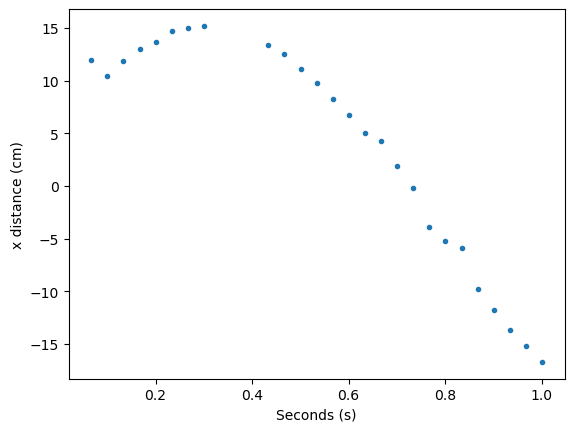

In [19]:
plt.scatter(time, rows[:, 0], marker='.')
plt.xlabel('Seconds (s)')
plt.ylabel('x distance (cm)')

Text(0, 0.5, 'y distance (cm)')

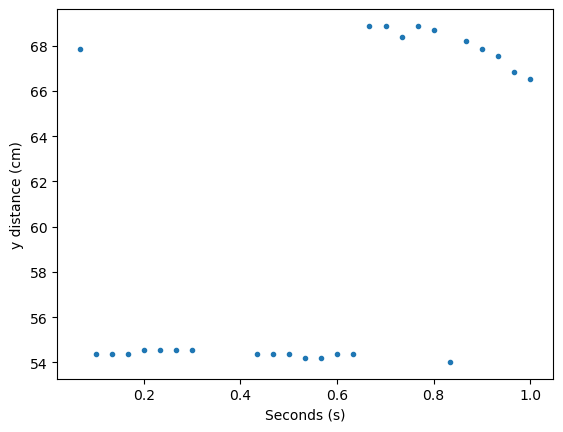

In [20]:
plt.scatter(time, rows[:, 1], marker='.')
plt.xlabel('Seconds (s)')
plt.ylabel('y distance (cm)')